In [1]:
%matplotlib inline

import os
import yaml

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import astropy.io.fits as pyfits
from astropy.io import fits
from astropy.table import Table
import astropy.units as u
from astropy.cosmology import WMAP9
from astropy.modeling.models import Schechter1D

import grizli
import grizli.catalog
from grizli import utils

from scipy.optimize import curve_fit
import pandas as pd

import eazy

print(f'grizli version: {grizli.__version__}')
print(f'eazy-py version: {eazy.__version__}')

Failed to `import dust_attenuation`
Install from the repo with $ pip install git+https://github.com/karllark/dust_attenuation.git
grizli version: 1.11.2
eazy-py version: 0.6.8


### Set field & path
`abell2744clu` = Abell 2744 GLASS + UNCOVER + DD-2756

`gds` = GOODS-South

In [2]:
field = 'abell2744clu-grizli-v7.0' 
url_path = 'https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7'

## Raw photometry

NB: All photometry given in `fnu` flux densities with units of `microJansky` (AB zeropoint = 23.9).

In [3]:
phot = utils.read_catalog(f'{url_path}/{field}-fix_phot_apcorr.fits')
print(type(phot))
phot.columns

<class 'grizli.utils.GTable'>


<TableColumns names=('id','thresh','npix','tnpix','xmin','xmax','ymin','ymax','x','y','x2_image','y2_image','xy_image','errx2','erry2','errxy','a_image','b_image','theta_image','cxx_image','cyy_image','cxy_image','cflux','flux','cpeak','peak','xcpeak','ycpeak','xpeak','ypeak','flag','x_image','y_image','number','ra','dec','x_world','y_world','flux_iso','fluxerr_iso','area_iso','mag_iso','kron_radius','kron_rcirc','flux_auto','fluxerr_auto','bkg_auto','flag_auto','area_auto','flux_radius_flag','flux_radius_20','flux_radius','flux_radius_90','tot_corr','mag_auto','magerr_auto','flux_aper_0','fluxerr_aper_0','flag_aper_0','bkg_aper_0','mask_aper_0','flux_aper_1','fluxerr_aper_1','flag_aper_1','bkg_aper_1','mask_aper_1','flux_aper_2','fluxerr_aper_2','flag_aper_2','bkg_aper_2','mask_aper_2','clearp-f356w_flux_aper_0','clearp-f356w_fluxerr_aper_0','clearp-f356w_flag_aper_0','clearp-f356w_bkg_aper_0','clearp-f356w_mask_aper_0','clearp-f356w_flux_aper_1','clearp-f356w_fluxerr_aper_1','clearp-

### Metadata

In [4]:
# General data of source detection
for i, k in enumerate(phot.meta):
    print(f'{k:>36} = {phot.meta[k]}')
    if i > 70:
        print('...')
        break

                             VERSION = 1.2.1
                             MINAREA = 9
                               CLEAN = True
                             DEBCONT = 0.001
                            DEBTHRSH = 32
                         FILTER_TYPE = conv
                           THRESHOLD = 1.5
                            KRONFACT = 2.5
                               KRON0 = 2.4
                               KRON1 = 3.8
                             MINKRON = 8.75000000000009
                            TOTCFILT = F140W
                            TOTCWAVE = 13922.907
                                  ZP = 28.9
                                PLAM = 13922.907
                                 FNU = 1e-08
                                FLAM = 1.4737148e-20
                              UJY2DN = 99.99395614709495
                            DRZ_FILE = abell2744clu-grizli-v7.0-ir_drc_sci.
                            WHT_FILE = abell2744clu-grizli-v7.0-ir_drc_wht.
                 

### Photometric apertures

In [5]:
for i, k in enumerate(phot.meta):
    if k.startswith('APER_'):
        aper_index = k[-1]
        print(f"Aperture index {aper_index}: *diameter* = {phot.meta[k]:4.1f} pixels = {phot.meta[k.replace('APER','ASEC')]:.2f} arcsec")

# Some observers use large apertures for their measurements to account for seeing, tracking, 
# and focus variations, while others use small apertures and apply aperture corrections (how do we choose here?)

Aperture index 0: *diameter* =  9.0 pixels = 0.36 arcsec
Aperture index 1: *diameter* = 12.5 pixels = 0.50 arcsec
Aperture index 2: *diameter* = 17.5 pixels = 0.70 arcsec
Aperture index 3: *diameter* = 25.0 pixels = 1.00 arcsec


In [6]:
# Columns for a particular filter + aperture
# bands in the HFF survey that cover the optical-IR: F435, F606, F814, F105, F140

aper_index = '1' 

cols = []

for k in phot.colnames:
    if k.startswith('f200w') & k.endswith(aper_index):
        cols.append(k)
        
phot[cols].info()

<GTable length=47888>
         name          dtype  unit    class     n_bad
--------------------- ------- ---- ------------ -----
    f200w_flux_aper_1 float64  uJy MaskedColumn  7839
 f200w_fluxerr_aper_1 float64  uJy MaskedColumn  7839
    f200w_flag_aper_1   int16      MaskedColumn     0
     f200w_bkg_aper_1 float64  uJy MaskedColumn  7839
    f200w_mask_aper_1 float64            Column     0
   f200wn_flux_aper_1 float64  uJy MaskedColumn 30738
f200wn_fluxerr_aper_1 float64  uJy MaskedColumn 30738
   f200wn_flag_aper_1   int16      MaskedColumn     0
    f200wn_bkg_aper_1 float64  uJy MaskedColumn 30738
   f200wn_mask_aper_1 float64            Column     0
         f200w_corr_1 float64  uJy       Column     0
        f200w_ecorr_1 float64  uJy       Column     0
          f200w_tot_1 float64  uJy       Column     0
         f200w_etot_1 float64  uJy       Column     0
        f200wn_corr_1 float64  uJy       Column     0
       f200wn_ecorr_1 float64  uJy       Column     0
      

### Photometric bands

- NIRCam filters generally have "clear" in the filter name, which is the element in the `pupil` wheel.
- Filters that start with `clearp` are generally the long-wavelength NIRISS filters.
- Filters with names that end in `wn` are the NIRISS versions, e.g., `f200wn-clear` for NIRISS and `f200w-clear` for NIRCam
- HST filters ending in "u" are the WFC3/UVIS versions, e.g., `f814wu`

In [7]:
# bands 
count = 0
for k in phot.colnames:
    if k.endswith('_tot_1'): 
        count += 1
        print(f"{count:>2} {k.split('_flux')[0]}")

 1 clearp-f356w_tot_1
 2 clearp-f444w_tot_1
 3 f090w_tot_1
 4 f105w_tot_1
 5 f115w_tot_1
 6 f115wn_tot_1
 7 f125w_tot_1
 8 f140w_tot_1
 9 f150w_tot_1
10 f150wn_tot_1
11 f160w_tot_1
12 f200w_tot_1
13 f200wn_tot_1
14 f277w_tot_1
15 f356w_tot_1
16 f410m_tot_1
17 f435w_tot_1
18 f444w_tot_1
19 f475w_tot_1
20 f606w_tot_1
21 f775w_tot_1
22 f814w_tot_1


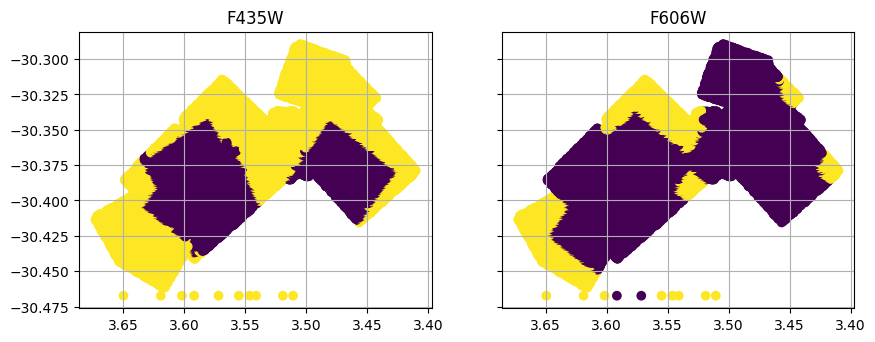

In [8]:
# Missing data are *masked* (?)

# bands in the HFF survey that cover the optical-IR: F435, F606, F814, F105, F140

fig, axes = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)

axes[0].scatter(phot['ra'], phot['dec'], c=phot['f435w_flux_aper_1'].mask)
axes[0].set_title('F435W') # what are (JADES/FRESCO)?
axes[1].scatter(phot['ra'], phot['dec'], c=phot['f606w_flux_aper_1'].mask)
axes[1].set_title('F606W')

axes[0].set_xlim(*axes[0].get_xlim()[::-1])
cosd = np.cos(np.nanmedian(phot['dec'])/180*np.pi)
for ax in axes:
    ax.set_aspect(1./cosd)
    ax.grid()

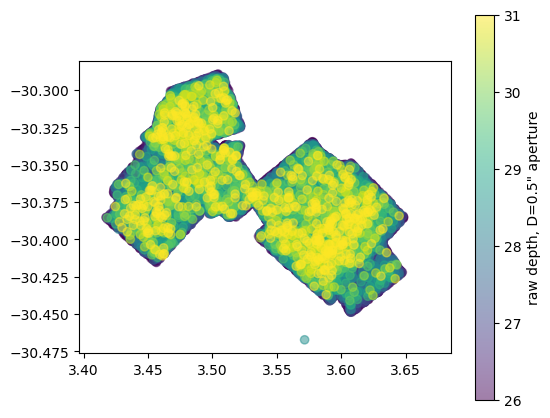

In [9]:
# 5-sigma depth in the D=0.5" aperture
depth = 23.9 - 2.5*np.log10(phot['f606w_flux_aper_1']*5) # how do you get 23.9?
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.set_aspect(1./cosd)
so = np.argsort(depth)
sc = ax.scatter(phot['ra'][so], phot['dec'][so], c=depth[so], vmin=26, vmax=31, alpha=0.5)
ax.set_xlim(*axes[0].get_xlim()[::-1])
cb = plt.colorbar(sc)
cb.set_label('raw depth, D=0.5" aperture')

### Point sources

Text(0, 0.5, 'flux_radius')

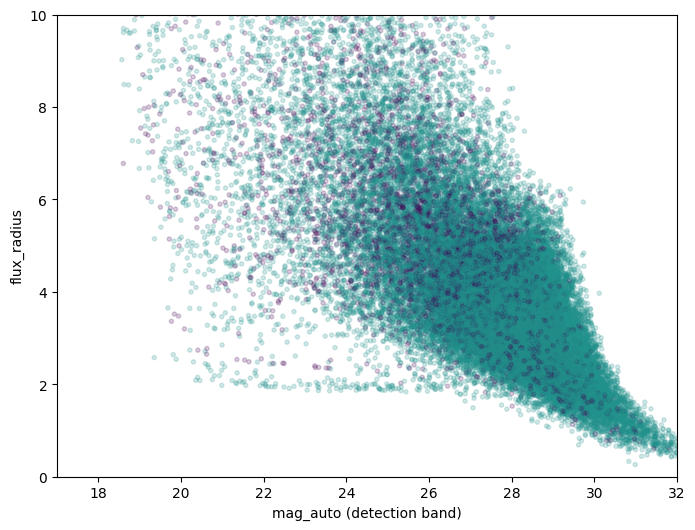

In [10]:
fig, ax = plt.subplots(1,1,figsize=(8, 6))
in_jades = ~phot['f200w_flux_aper_1'].mask
ax.scatter(phot['mag_auto'], phot['flux_radius'], alpha=0.2, c=in_jades, vmin=0, vmax=2, cmap='viridis', marker='.')
ax.set_ylim(0,10); ax.set_xlim(17, 32)

ax.set_xlabel('mag_auto (detection band)'); ax.set_ylabel('flux_radius') # limit from -1 because below that pixels are so small it gets noise (half light radius)


In [11]:
phot.columns

<TableColumns names=('id','thresh','npix','tnpix','xmin','xmax','ymin','ymax','x','y','x2_image','y2_image','xy_image','errx2','erry2','errxy','a_image','b_image','theta_image','cxx_image','cyy_image','cxy_image','cflux','flux','cpeak','peak','xcpeak','ycpeak','xpeak','ypeak','flag','x_image','y_image','number','ra','dec','x_world','y_world','flux_iso','fluxerr_iso','area_iso','mag_iso','kron_radius','kron_rcirc','flux_auto','fluxerr_auto','bkg_auto','flag_auto','area_auto','flux_radius_flag','flux_radius_20','flux_radius','flux_radius_90','tot_corr','mag_auto','magerr_auto','flux_aper_0','fluxerr_aper_0','flag_aper_0','bkg_aper_0','mask_aper_0','flux_aper_1','fluxerr_aper_1','flag_aper_1','bkg_aper_1','mask_aper_1','flux_aper_2','fluxerr_aper_2','flag_aper_2','bkg_aper_2','mask_aper_2','clearp-f356w_flux_aper_0','clearp-f356w_fluxerr_aper_0','clearp-f356w_flag_aper_0','clearp-f356w_bkg_aper_0','clearp-f356w_mask_aper_0','clearp-f356w_flux_aper_1','clearp-f356w_fluxerr_aper_1','clearp-

## RA vs Dec

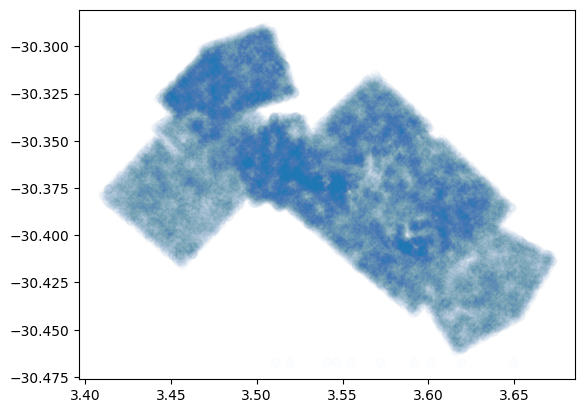

In [12]:
# RA vs Dec
plt.scatter(phot['ra'], phot['dec'], vmin=3.4, vmax=3.6, alpha=0.01)
# plt.scatter(phot['x_world'], phot['y_world'], vmin=3.4, vmax=3.6, alpha=0.01) # <-- celestial coordinates

# Photometric redshifts

In [13]:
import eazy.hdf5

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs()

root = f'{field}-fix'

self = eazy.hdf5.initialize_from_hdf5(h5file=root+'.eazypy.h5')

zout = utils.read_catalog(root+'.eazypy.zout.fits')
self.cat = utils.read_catalog(root+'_phot_apcorr.fits')
cat = self.cat

Read default param file: /home/codespace/.python/current/lib/python3.10/site-packages/eazy/data/zphot.param.default


CATALOG_FILE is a table
   >>> NOBJ = 47888
f090w_tot_1 f090w_etot_1 (363): jwst_nircam_f090w
f105w_tot_1 f105w_etot_1 (202): hst/wfc3/IR/f105w.dat
f115w_tot_1 f115w_etot_1 (364): jwst_nircam_f115w
f115wn_tot_1 f115wn_etot_1 (309): niriss-f115w
f125w_tot_1 f125w_etot_1 (203): hst/wfc3/IR/f125w.dat
f140w_tot_1 f140w_etot_1 (204): hst/wfc3/IR/f140w.dat
f150w_tot_1 f150w_etot_1 (365): jwst_nircam_f150w
f150wn_tot_1 f150wn_etot_1 (310): niriss-f150w
f160w_tot_1 f160w_etot_1 (205): hst/wfc3/IR/f160w.dat
f200w_tot_1 f200w_etot_1 (366): jwst_nircam_f200w
f200wn_tot_1 f200wn_etot_1 (311): niriss-f200w
f277w_tot_1 f277w_etot_1 (375): jwst_nircam_f277w
f356w_tot_1 f356w_etot_1 (376): jwst_nircam_f356w
f410m_tot_1 f410m_etot_1 (383): jwst_nircam_f410m
f435w_tot_1 f435w_etot_1 (233): hst/ACS_update_sep07/wfc_f435w_t81.dat
f444w_tot_1 f444w_etot_1 (377): jwst_nircam_f444w
f475w_tot_1 f475w_etot_1 (234): hst/ACS_update_sep07/wfc_f475w_t81.dat
f606w_tot_1 f606w_etot_1 (236): hst/ACS_update_sep07/wfc_

294it [00:02, 104.48it/s]


h5: read corr_sfhz_13_bin0_av0.01.fits
h5: read corr_sfhz_13_bin0_av0.25.fits
h5: read corr_sfhz_13_bin0_av0.50.fits
h5: read corr_sfhz_13_bin0_av1.00.fits
h5: read corr_sfhz_13_bin1_av0.01.fits
h5: read corr_sfhz_13_bin1_av0.25.fits
h5: read corr_sfhz_13_bin1_av0.50.fits
h5: read corr_sfhz_13_bin1_av1.00.fits
h5: read corr_sfhz_13_bin2_av0.01.fits
h5: read corr_sfhz_13_bin2_av0.50.fits
h5: read corr_sfhz_13_bin2_av1.00.fits
h5: read corr_sfhz_13_bin3_av0.01.fits
h5: read corr_sfhz_13_bin3_av0.50.fits
h5: read fsps_4590.fits
h5: read j0647agn+torus.fits
fit_best: 16.3 s (n_proc=2,  NOBJ=46441)


In [14]:
#plt.scatter(zout['z_phot'], zout['z_spec'])

Text(0.5, 1.0, 'JWST abell2744clu-grizli-v7.0')

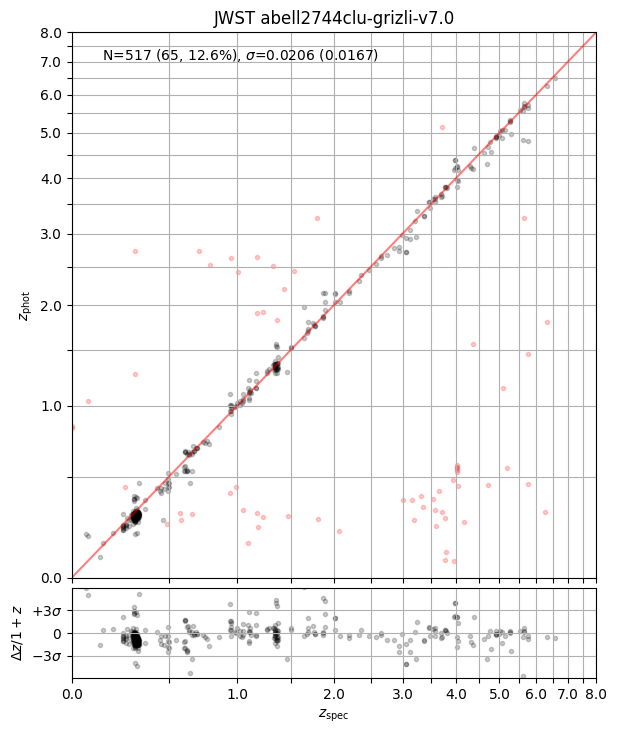

In [15]:
fig = eazy.utils.zphot_zspec(zout['z_phot'], zout['z_spec'], zmax=8)
fig.axes[0].set_title(f'JWST {field}')

In [16]:
# fig = eazy.utils.zphot_zspec(phot['mag_iso'], zout['z_phot'], zmax=8)
mag_f200 = 23.9 - 2.5*np.log10(phot['f200w_tot_1']) # apparent magnitude using zero point of 23.9
mag_f150 = 23.9 - 2.5*np.log10(phot['f150w_tot_1']) # jwst
mag_f160 = 23.9 - 2.5*np.log10(phot['f160w_tot_1']) 
mag_f814 = 23.9 - 2.5*np.log10(phot['f814w_tot_1']) 

# f160-f150 ~ 0
# f200 not masked

Text(0.5, 1.0, 'Photometric redshift distribution - Abell 2744')

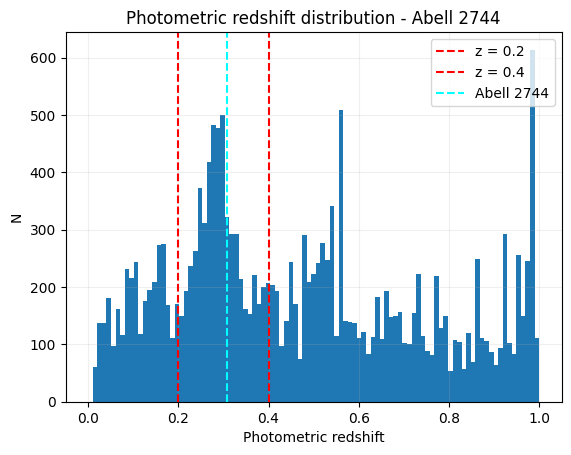

In [17]:
plt.hist(zout['z_phot'], bins=np.linspace(0, 1, 100)) # bin this differently
minl = 0.2
maxl = 0.4
plt.axvline(minl, linestyle='--', color='red', label='z = ' + str(minl))
plt.axvline(maxl, linestyle='--', color='red', label='z = ' + str(maxl))
plt.axvline(0.308, linestyle='--', color='cyan', label='Abell 2744')
plt.grid(alpha=0.2)
plt.legend()
plt.xlabel('Photometric redshift'); plt.ylabel('N'); plt.title('Photometric redshift distribution - Abell 2744')
## Likelihood that a particular galaxy is a cluster member -> galaxies < 0 and > 7.5 are foreground/background objects?

(0.0, 1.0)

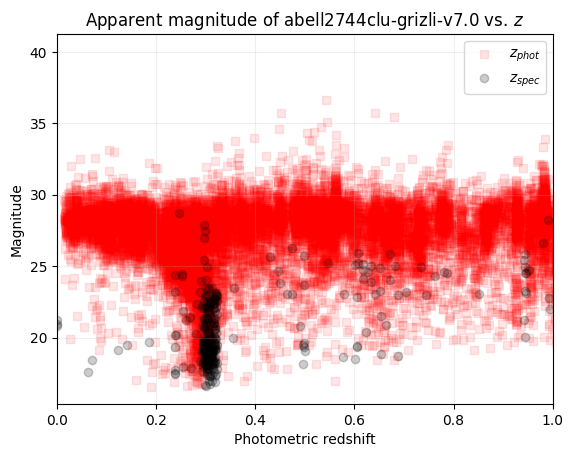

In [18]:
plt.scatter(zout['z_phot'], mag_f200, marker='s', alpha=0.1, label='$z_{phot}$', color='red')
plt.scatter(zout['z_spec'], mag_f200, marker='o', alpha=0.2, label='$z_{spec}$', color='black')
plt.legend(); plt.title(f'Apparent magnitude of {field} vs. $z$')
plt.ylabel('Magnitude'); plt.xlabel('Photometric redshift')
plt.grid(alpha=0.2)
plt.xlim(0, 1)

### min/max range to help select cluster members

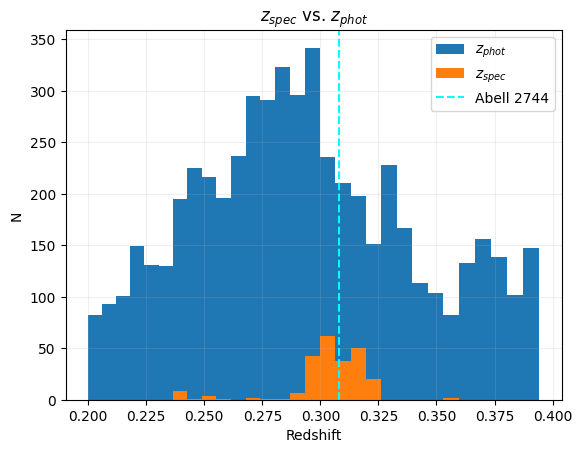

In [19]:
plt.hist(zout['z_phot'], bins=eazy.utils.log_zgrid([0.20,0.40], 0.005), label='$z_{phot}$')
plt.hist(zout['z_spec'], bins=eazy.utils.log_zgrid([0.20,0.40], 0.005), label='$z_{spec}$')
plt.axvline(0.308, linestyle='--', color='cyan', label='Abell 2744')
plt.xlabel('Redshift'); plt.ylabel('N')
plt.grid(alpha=0.2)
plt.title('$z_{spec}$ vs. $z_{phot}$')
plt.legend()

## Colour-colour diagrams

In [20]:
self

In [ ]:
### USING EAZY rest_frame_fluxes()
"""
_ubvj = (,,) ->
ubvj_tempfilt = rf integrated template fluxes (total through a filter)
ubvj_lc = rf pivot wavelengths (effective wavelength based on filter's transmission properties)
ubvj = rf fluxes
"""
_ubvj = self.rest_frame_fluxes()
UBVJ = [153,154,155,161] # default UBVJ filters
self.ubvj_tempfilt, self.ubvj_lc, self.ubvj = _ubvj
self.ubvj_f_numbers = UBVJ
      
restU_eazy = self.ubvj[:,0,2] # flux density
restV_eazy = self.ubvj[:,2,2]
restJ_eazy = self.ubvj[:,3,2]

UV_eazy = -2.5*np.log10(restU_eazy/restV_eazy) # rest-frame with AB magnitude
VJ_eazy = -2.5*np.log10(restV_eazy/restJ_eazy)


Rest-frame filters:
~~~~~~~~~~~~~~~~~~~ 
   0 REST_FRAME/maiz-apellaniz_Johnson_U.res 2006AJ....131.1184M lambda_c= 3.5900e+03 AB-Vega= 0.769 w95=862.3
   1 REST_FRAME/maiz-apellaniz_Johnson_B.res 2006AJ....131.1184M lambda_c= 4.3722e+03 AB-Vega=-0.106 w95=1321.3
   2 REST_FRAME/maiz-apellaniz_Johnson_V.res 2006AJ....131.1184M lambda_c= 5.4794e+03 AB-Vega= 0.002 w95=1369.1
   3 2MASS/J.res lambda_c= 1.2358e+04 AB-Vega= 0.885 w95=2311.1


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [07:35<00:00, 91.11s/it] 

 ... rest-frame flux: 455.7 s (n_proc=2,  NOBJ=46957)


In [21]:
## using zout and sps_parameters()

restU = zout['restU']
restV = zout['restV']
restJ = zout['restJ']

UV = -2.5*np.log10(restU/restV) # rest-frame with AB magnitude
VJ = -2.5*np.log10(restV/restJ) 

Text(0.5, 1.0, 'UVJ diagram - master')

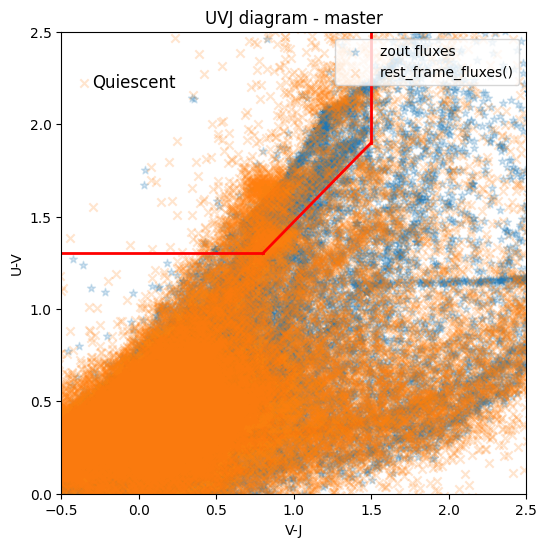

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6)) # top left part is quiescent

# lines based on Muzzin 2013
ax.plot([-0.5,0.8],[1.3,1.3],'r',lw=2) # left
ax.plot([0.8,1.5],[1.3,1.9],'r',lw=2) # diag
ax.plot([1.5,1.5],[1.9,2.5],'r',lw=2) # top

plt.scatter(VJ, UV, alpha=0.2, marker='*', label='zout fluxes')
plt.scatter(VJ_eazy, UV_eazy, alpha=0.2, marker='x', label='rest_frame_fluxes()')
plt.xlabel('V-J'); plt.ylabel('U-V')
plt.xlim(-0.5, 2.5); plt.ylim(0, 2.5)
plt.legend(loc='upper right')
ax.text(-0.3,2.2,'Quiescent',fontsize=12)
plt.title('UVJ diagram - master')

# dusty star-forming galaxies are red in V–J, quiescent galaxies are blue in V–J

In [22]:
# Creating a master dataframe of (z, U, V, J) in order to index by redshift
df = pd.DataFrame()

df['z_phot'] = list(zout['z_phot'])
df['U'] = list(restU)
df['V'] = list(restV)
df['J'] = list(restJ)
df['mag'] = mag_f200

df['mag'] = df['mag'].fillna(-1)
df = df[df['mag'] > -1] # only valid ones now

df

,z_phot,U,V,J,mag
10,2.438246,-0.000007,-0.000156,-0.003247,31.106006
11,3.273083,0.026003,0.032111,0.013620,27.145678
12,1.369503,0.053349,0.051153,0.066844,27.071478
13,0.592300,0.213709,0.401163,0.542543,24.457128
14,0.943194,0.007413,0.011538,0.017594,28.059074
...,...,...,...,...,...
47883,3.093199,0.030869,0.045687,0.183679,26.889783
47884,0.732545,0.038687,0.068179,0.077431,26.554224
47885,0.672800,0.318292,1.059566,6.777478,21.795159
47886,0.340983,0.028254,0.042784,0.059217,26.795970


In [35]:
import matplotlib.patches as mpatches

In [57]:
def UVJ_diagram(df):
    """ For a given dataframe of shape (z, U, V, J, mag), 
        return the minimum and maximum z and UV and VJ bands
    """
    min_z = min(df['z_phot'])
    max_z = max(df['z_phot'])
    UV = -2.5*np.log10(df['U']/df['V'])
    VJ = -2.5*np.log10(df['V']/df['J'])
    
    return min_z, max_z, VJ, UV

def line(x):
    y = 0.857*x + 0.614
    return y

def plot_df_subsets(zs, cut='', alpha=0.1):
    """ Subplots for each range of z in zs (also cuts for magnitude if applicable)
    """
    fig, axs = plt.subplots(3, 2, figsize=(8, 10), sharex=True, sharey=True)
    fig.suptitle('UVJ Diagram - Abell 2744' + ' (' + cut + ')')

    for i, variable in enumerate(zs):
        x = i//2; y = i%2 

        a, b = list(UVJ_diagram(zs[i])[2]), list(UVJ_diagram(zs[i])[3])

        for q in range(len(a)):
            if (a[q] < 0.8 and b[q] > 1.3) or (0.8 < a[q] < 1.5 and b[q] > line(a[q])) or (a[q] < 1.5 and b[q] > 1.9):
                axs[x,y].scatter(a[q], b[q], color='red', alpha=alpha, marker='*') 
            else:
                axs[x,y].scatter(a[q], b[q], color='tab:blue', alpha=alpha, marker='*') 

        axs[x,y].scatter(-1,2, color='red', alpha=0.5, marker='*', label='Quiescent') 
        axs[x,y].scatter(3,0.5, color='tab:blue', alpha=0.5, marker='*', label='Star-Forming') 
        axs[x,y].legend(loc='lower right', fontsize='x-small')

        axs[x,y].set_xlim(-0.5, 2.5); axs[x,y].set_ylim(0, 2.5)
        axs[x,y].text(-0.2, 2.2, str(round(UVJ_diagram(zs[i])[0], 2))+' $\leq$ z $\leq$ '+str(round(UVJ_diagram(zs[i])[1], 2)),fontsize=10)
        axs[x,y].set_xlabel('V-J')
        axs[x,y].set_ylabel('U-V')  

        axs[x,y].grid(alpha=0.7)

        # Plotting lines
        axs[x,y].plot([-0.5,0.8],[1.3,1.3],'k',lw=2) # left
        axs[x,y].plot([0.81,1.5],[1.3,1.9],'k',lw=2) # diag
        axs[x,y].plot([1.5,1.5],[1.9,2.5],'k',lw=2) # top

    plt.tight_layout()
    plt.show()

    return # concentrated cluster galaxies & background galaxies deviating in colour?

In [46]:
# Creating dataframes for different ranges of redshift

z1 = df[(df['z_phot'] >= 0.05) & (df['z_phot'] <= 0.25)]
z2 = df[(df['z_phot'] > 0.25) & (df['z_phot'] <= 0.35)] # explore more with this one
z3 = df[(df['z_phot'] > 0.35) & (df['z_phot'] <= 0.6)]
z4 = df[(df['z_phot'] > 0.6) & (df['z_phot'] <= 0.95)]
z5 = df[(df['z_phot'] > 0.95) & (df['z_phot'] <= 1.35)]
z6 = df[(df['z_phot'] > 1.35) & (df['z_phot'] <= 1.90)]

zs=[z1,z2,z3,z4 ,z5, z6]

c = 0
for z in zs:
    print(len(z))
    c += (len(z))

print(c / len(df) * 100, '%')

3454
3317
3670
3593
3809
3799
56.324172392254845 %


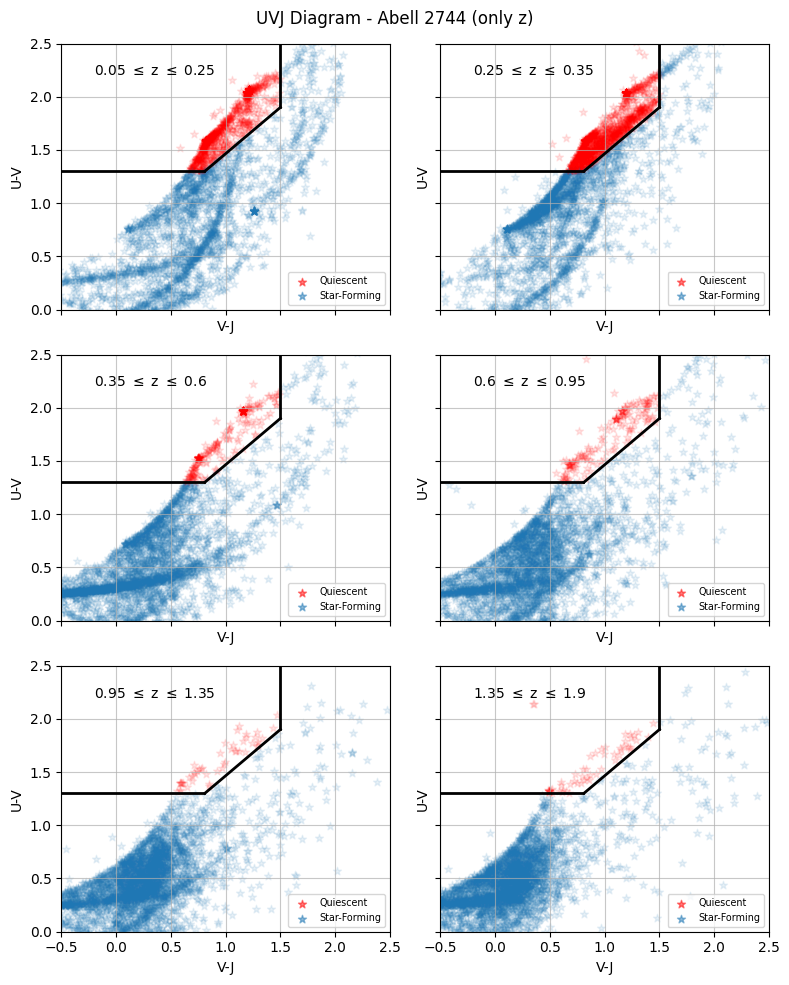

In [48]:
plot_df_subsets(zs, cut='only z')

## Zooming into cluster!

933
695
991
903
858
730
13.298979804288985 %


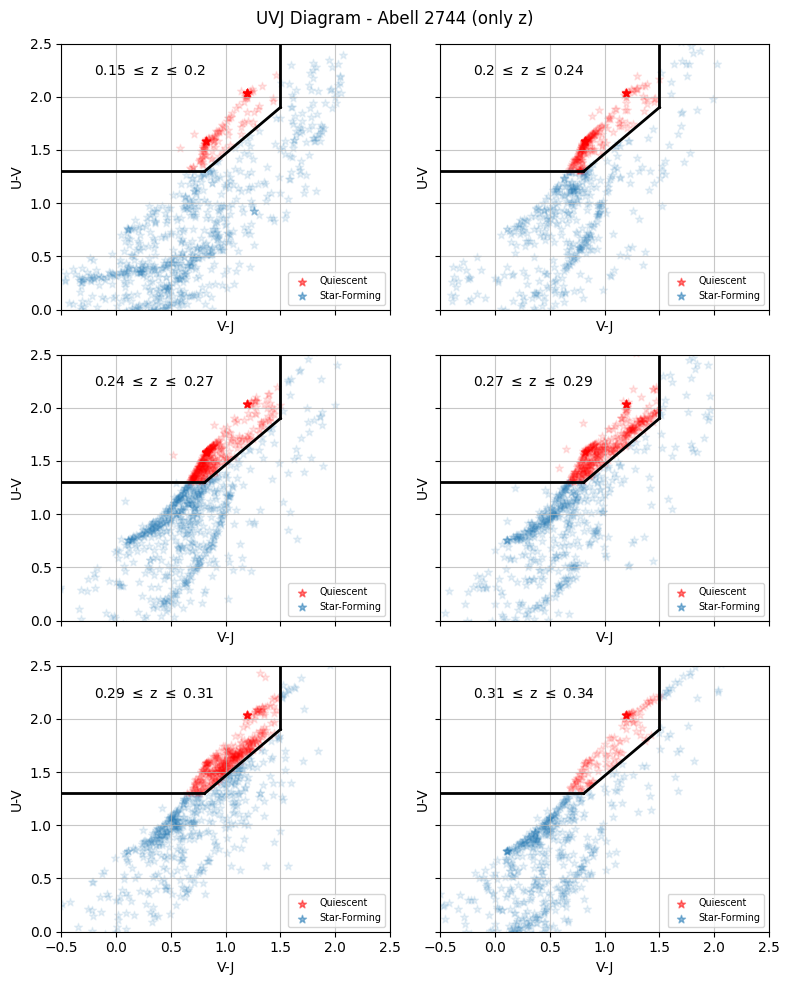

In [49]:
# Creating dataframes for different ranges of redshift

z1 = df[(df['z_phot'] > 0.15) & (df['z_phot'] <= 0.20)]
z2 = df[(df['z_phot'] > 0.20) & (df['z_phot'] <= 0.24)]
z3 = df[(df['z_phot'] > 0.24) & (df['z_phot'] <= 0.27)]
z4 = df[(df['z_phot'] > 0.27) & (df['z_phot'] <= 0.29)]
z5 = df[(df['z_phot'] > 0.29) & (df['z_phot'] <= 0.31)]
z6 = df[(df['z_phot'] > 0.31) & (df['z_phot'] <= 0.34)]

zs=[z1,z2,z3 ,z4 ,z5,z6]

c = 0
for z in zs:
    print(len(z))
    c += (len(z))

print(c / len(df) * 100, '%')

plot_df_subsets(zs, cut='only z')

## Magnitude

In [50]:
len(mag_f814) - len(np.unique(mag_f814))

17257

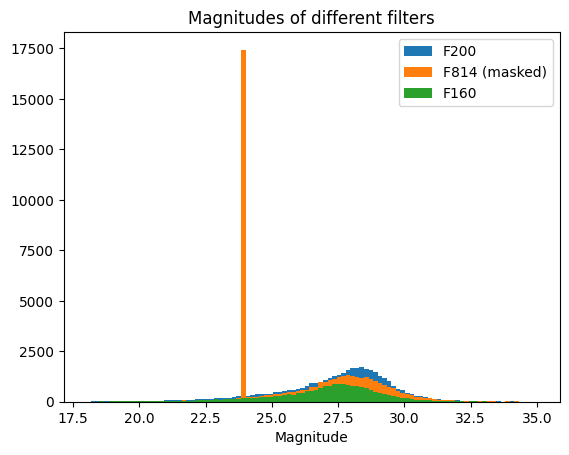

In [51]:
plt.hist(mag_f200, bins=np.linspace(18, 35, 100), label='F200')
plt.hist(mag_f814, bins=np.linspace(18, 35, 100), label='F814 (masked)')
plt.hist(mag_f160, bins=np.linspace(18, 35, 100), label='F160')
plt.xlabel('Magnitude')
plt.title('Magnitudes of different filters')
plt.legend()


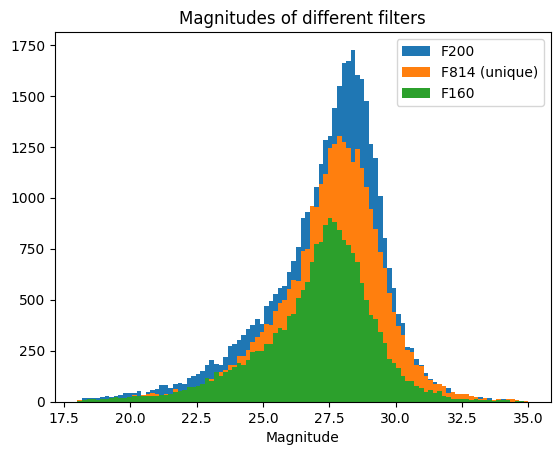

In [52]:
plt.hist(mag_f200, bins=np.linspace(18, 35, 100), label='F200')
plt.hist(np.unique(mag_f814), bins=np.linspace(18, 35, 100), label='F814 (unique)')
plt.hist(mag_f160, bins=np.linspace(18, 35, 100), label='F160')
plt.xlabel('Magnitude')
plt.title('Magnitudes of different filters')
plt.legend()


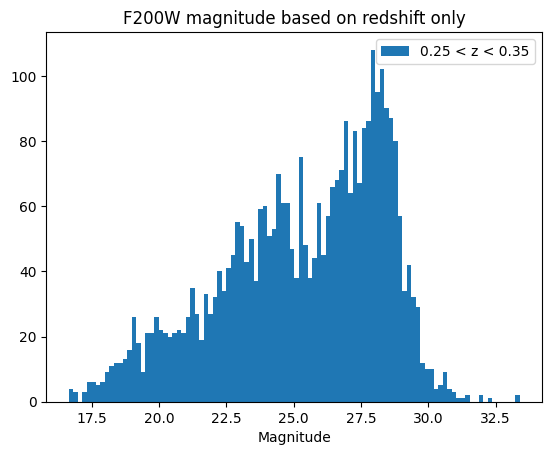

In [53]:
# NO MAGNITUDE BINS:
df_cut =  df[(df['z_phot'] > 0) & (df['z_phot'] <= 18)]
df_cut1 =  df[(df['z_phot'] > 0.25) & (df['z_phot'] <= 0.35)]
              
#plt.hist(df_cut['mag'], bins=100, label='0 < z < 18')
plt.hist(df_cut1['mag'], bins=100, label='0.25 < z < 0.35')
plt.xlabel('Magnitude')
plt.title('F200W magnitude based on redshift only')

plt.legend()

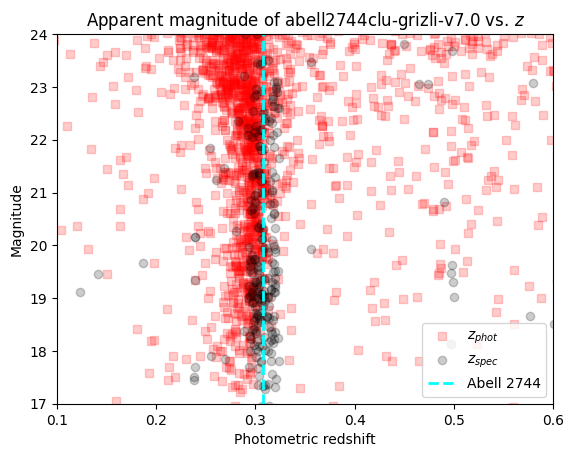

In [54]:
plt.scatter(zout['z_phot'], mag_f200, marker='s', alpha=0.2, label='$z_{phot}$', color='red')
plt.scatter(zout['z_spec'], mag_f200, marker='o', alpha=0.2, label='$z_{spec}$', color='black')
plt.title(f'Apparent magnitude of {field} vs. $z$')
plt.ylabel('Magnitude'); plt.xlabel('Photometric redshift')

plt.xlim(0.1, 0.6); plt.ylim(17, 24)
plt.axvline(0.308, color='cyan', linestyle='--', linewidth=2, label='Abell 2744')
plt.legend()

# make alpha lower to see transparency

### Binning for magnitude - UVJ Diagrams

In [55]:
# Creating dataframes for different ranges of magnitude (on top of redshift)
ms = []

for z in zs:
    m_cut = z[(z['mag'] >= 18) & (z['mag'] <= 23)]
    ms.append(m_cut)

for m in ms:
    print(len(m))

18
19
82
202
377
76


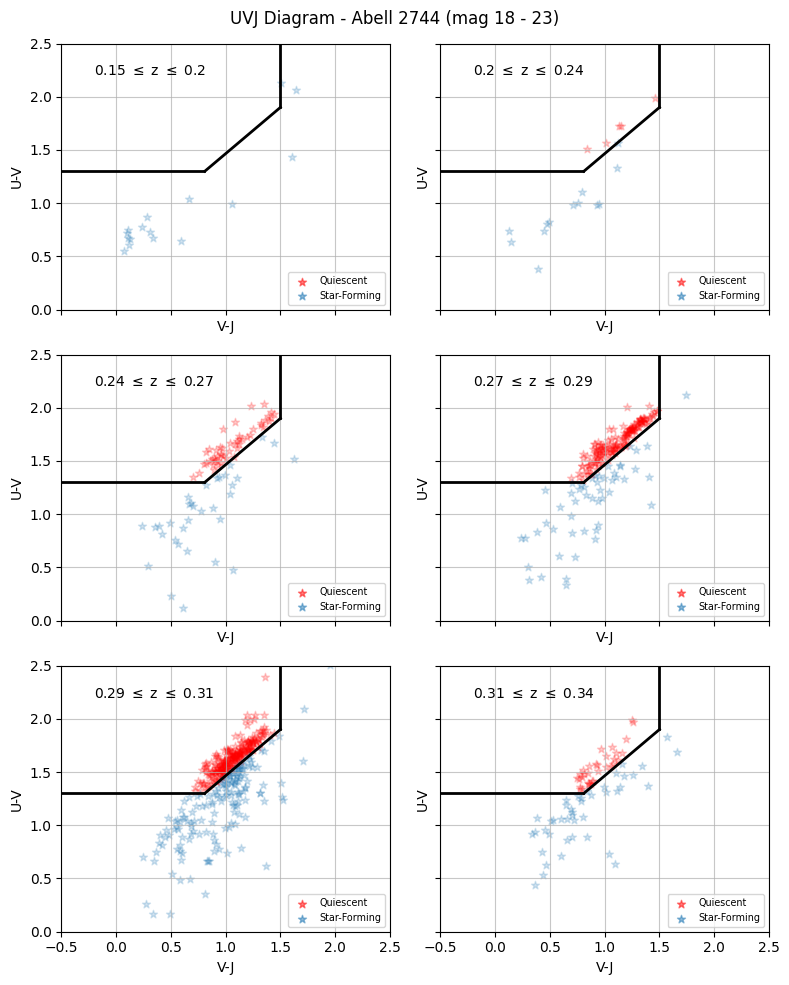

In [61]:
plot_df_subsets(ms, cut='mag 18 - 23', alpha=0.2) # cut more into ms[2] to see cluster; plot magnitudes by colour

## Luminosity Function

0 3
1 4
2 18
3 26
4 32
5 43
6 66
7 76
8 83
9 87
10 94
11 99
12 100
13 129
14 133
15 168
16 178
17 185
18 214
19 223
20 225
21 228
22 229
23 242
24 247
25 249
26 254
27 263
28 264
29 284
30 297
31 299
32 315
33 349
34 368
35 374
36 378
37 391
38 392
39 393
40 434
41 443
42 445
43 467
44 482
45 488
46 507
47 516
48 543
49 544
50 547
51 561
52 566
53 576
54 583
55 585
56 634
57 638
58 647
59 654
60 656
61 657
62 658
63 660
64 663
65 676
66 682
67 684
68 687
69 702
70 717
71 729
72 735
73 736
74 747
75 751
76 752
77 754
78 778
79 781
80 782
81 787
82 808
83 809
84 816
85 817
86 828
87 831
88 850
89 867
90 870
91 887
92 900
93 905
94 910
95 916
96 919
97 921
98 932
99 939
100 943
101 963
102 968
103 981
104 989
105 993
106 1003
107 1019
108 1023
109 1054
110 1102
111 1108
112 1113
113 1135
114 1144
115 1162
116 1164
117 1174
118 1176
119 1177
120 1179
121 1182
122 1186
123 1195
124 1202
125 1206
126 1207
127 1208
128 1229
129 1231
130 1233
131 1260
132 1264
133 1293
134 1302
135 1322
136 13

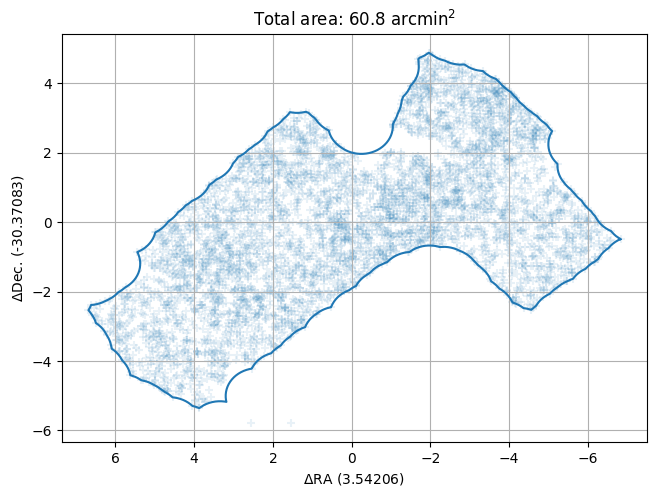

In [62]:
area, area_fig = grizli.utils.catalog_area(phot['ra'], phot['dec']) # square arcminutes

In [162]:
def normalization_param(z1, z2, area):
    """ unitless area
    """
    area *=  u.arcmin**2
    area_ster = area.to(u.steradian, equivalencies=u.dimensionless_angles())
    vol_in = WMAP9.comoving_volume(z1)
    vol_out = WMAP9.comoving_volume(z2)
    return (np.abs(vol_out-vol_in)) - (area_ster / (2 * np.pi*u.steradian))

# Schechter function:
def schechter(mag, scale_factor=11, M_star=21.9,a=-1.19): # use scipy to fit values for m_star, a, phi, also look at literature
    func = scale_factor * 0.4*np.log(10) * (10**(0.4*(M_star-mag)))**(a+1) * np.exp(10**(0.4*(M_star-mag)))   
    return func

In [193]:
def plot_sch(phi_star, m_star, alpha, mag):
    """ phi_star = normalization factor in units of number density
        m_star = characteristic magnitude where  power-law form cuts off into the exponential form
        alpha = power-law index (faint-end slope of the luminosity function)
    """
    phi_star = phi_star  * (u.Mpc ** -3)
    m_star = m_star
    alpha = alpha
    mag = mag
    model = Schechter1D(phi_star, m_star, alpha)

    plt.scatter(mag, model(mag))
    plt.yscale('log')
    plt.xlabel('F200W Magnitude'); plt.ylabel('$\phi^{*} [$Mpc^{-3} {mag}^{-1}$]')
    plt.title('Schechter Luminosity Function')


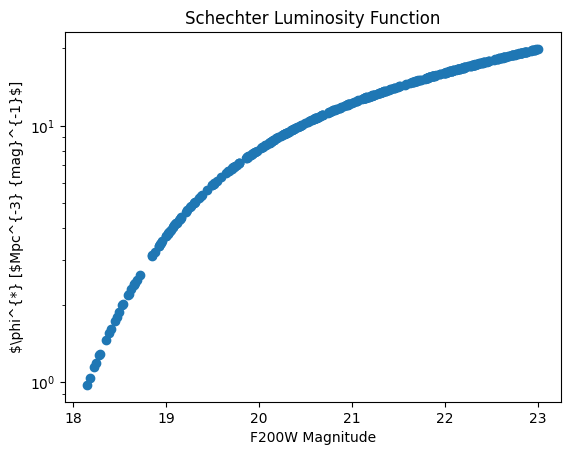

In [194]:
plot_sch(phi_star=11, m_star=19, alpha=-1.19, mag=ms[4]['mag'])

In [ ]:
## do the same bins for gds to compare as the field, except luminosity function

## Star formation rate!

Text(0, 0.5, 'log(SFR) [$M_\\odot \\ yr^{-1}$]')

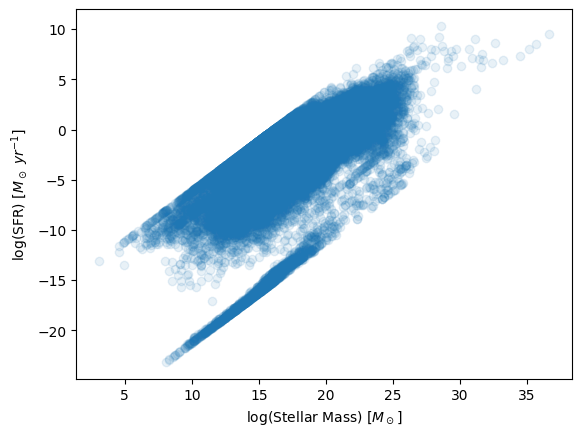

In [65]:
plt.scatter(np.log(zout['mass'][zout['mass'] > 0]), np.log(zout['sfr'][zout['sfr'] > 0]), alpha=0.1)
plt.xlabel('log(Stellar Mass) [$M_\odot$]'); plt.ylabel('log(SFR) [$M_\odot \ yr^{-1}$]')